In [1]:
import pandas as pd
import numpy as np
import torch.multiprocessing as mp
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from LEN_Scorer import Scorer
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.interpolate import interp1d
from Categorization import Categorizer
import copy

In [2]:
mimicDF = pd.read_csv("../LEN_Test/data/TimeSeries.csv")
targetDF = mimicDF['Mortality14Days']
mimicDF = mimicDF.drop(['Mortality14Days'], axis=1)
mimicDF

,PatientID,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,Arterial PaO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
0,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47083,159740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47084,159740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47085,159740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47086,159740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
mimicDF.describe()

,PatientID,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,Arterial PaO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
count,47088.000000,484.000000,481.000000,705.000000,245.000000,31415.000000,31503.000000,31504.000000,8601.000000,8582.000000,...,12981.000000,14768.000000,14714.000000,4352.000000,2485.000000,32961.000000,85.000000,26516.000000,331.000000,2118.000000
mean,151079.910805,630.123967,954.301455,67.382553,2.721633,77.058157,57.226709,117.544502,40.565399,152.720982,...,33.217492,987.290546,1917.421073,96.799012,138.022942,97.267665,64.988235,37.235334,2.529305,12.747691
std,29378.613191,1245.805613,2384.326867,5.448469,0.584693,14.324177,11.197415,21.311674,7.078312,92.767596,...,10.474703,363.504762,608.801780,2.659592,5.435978,3.083466,10.518118,1.399548,3.004787,5.523420
min,100059.000000,3.000000,3.000000,48.000000,1.400000,0.000000,0.000000,0.000000,15.000000,7.470000,...,0.000000,0.000000,0.000000,42.000000,1.210000,0.000000,43.000000,0.000000,0.000000,1.900000
25%,126241.000000,25.000000,49.000000,64.000000,2.400000,68.000000,50.000000,103.000000,36.000000,90.000000,...,26.168200,737.500000,1494.877533,96.000000,136.000000,96.000000,58.000000,36.900002,0.600000,9.000000
50%,151857.000000,97.000000,137.000000,68.000000,2.700000,75.000000,56.000000,115.000000,40.000000,118.000000,...,31.460699,931.028503,1841.049988,97.000000,138.000000,98.000000,65.000000,37.299999,1.400000,11.900000
75%,176484.000000,554.750000,797.000000,70.000000,3.000000,84.000000,63.000000,129.000000,44.000000,174.750000,...,38.118801,1169.229980,2244.340088,98.000000,140.000000,100.000000,71.000000,37.700001,3.300000,15.500000
max,199998.000000,8100.000000,23060.000000,160.000000,4.400000,287.000000,191.000000,255.000000,91.000000,499.000000,...,179.212997,3784.620117,6000.000000,100.000000,164.000000,100.000000,100.000000,46.500000,16.400000,48.300000


In [4]:
print(f"There are {mimicDF['PatientID'].nunique()} unique patients in the dataset")

There are 1126 unique patients in the dataset


In [5]:
class Reading:

    def __init__(self, time, readingData):
        self.time = time
        self.readingData = readingData

    def __repr__(self):
        return f"Time_index: {self.time}\n Data: {self.readingData}"

In [6]:
class Patient:

    def __init__(self, patientID, data):
        self.patientID = patientID
        self.data = data


    def __repr__(self):
        return f"PatientID: {self.patientID}\n Readings: {self.data}"
    

In [7]:
for id in mimicDF['PatientID'].unique()[:1]:
    patientDF = mimicDF[mimicDF['PatientID'] == id]
    display(patientDF)

,PatientID,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,Arterial PaO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
0,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
patients = []

for id in mimicDF['PatientID'].unique():
    patientDF = mimicDF[mimicDF['PatientID'] == id].reset_index().drop(columns=['PatientID', 'index'])
    patient = Patient(id, patientDF)
    patients.append(patient)

print(len(patients))

1126


In [9]:
print(patients[1].data)

    ALT  AST  Admit Ht  Albumin  Arterial BP Mean  Arterial BP [Diastolic]  \
0   NaN  NaN       NaN      NaN              84.0                     46.0   
1   NaN  NaN       NaN      NaN              85.0                     60.0   
2   NaN  NaN       NaN      NaN              84.0                     54.0   
3   NaN  NaN       NaN      NaN              91.0                     55.0   
4   NaN  NaN       NaN      NaN              68.0                     43.0   
5   NaN  NaN       NaN      NaN              82.0                     52.0   
6   NaN  NaN      68.0      NaN               NaN                     49.0   
7   NaN  NaN       NaN      NaN              72.0                     45.0   
8   NaN  NaN       NaN      NaN              68.0                     43.0   
9   NaN  NaN       NaN      NaN              71.0                     43.0   
10  NaN  NaN       NaN      NaN              70.0                     42.0   
11  NaN  NaN       NaN      NaN              84.0               

In [10]:
cleaningDF = patients[1].data
cleaningDF.head()

,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,Arterial PaO2,Arterial pH,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
0,NaN,NaN,NaN,NaN,84.0,46.0,116.0,NaN,NaN,NaN,...,21.844700,1094.020020,2255.510010,NaN,NaN,97.0,NaN,37.200001,NaN,NaN
1,NaN,NaN,NaN,NaN,85.0,60.0,129.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,99.0,NaN,37.200001,NaN,NaN
2,NaN,NaN,NaN,NaN,84.0,54.0,117.0,42.0,90.0,7.36,...,NaN,NaN,NaN,NaN,NaN,99.0,NaN,37.099998,NaN,NaN
3,NaN,NaN,NaN,NaN,91.0,55.0,125.0,NaN,NaN,7.29,...,25.242701,1146.900024,2364.959961,NaN,NaN,93.0,NaN,37.000000,NaN,NaN
4,NaN,NaN,NaN,NaN,68.0,43.0,96.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,93.0,NaN,36.799999,NaN,NaN


In [11]:
columnsToInterpolate = ['Glucose']

noInterpolation = 0

interpolatedPatients = patients.copy()

for patient in interpolatedPatients:
    try:
        patient.data[columnsToInterpolate] = patient.data[columnsToInterpolate].apply(lambda x: x.interpolate(method='polynomial', order=2))
    except ValueError:
        noInterpolation += 1
        continue

print(f"{noInterpolation}/{len(patients)} patients have no missing values")

65/1126 patients have no missing values


In [12]:
cleaningDF = patients[0].data[columnsToInterpolate]
cleaningDF

,Glucose
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,NaN


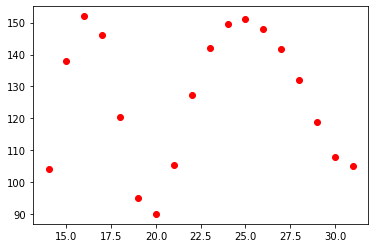

In [13]:
glucoseSeries = cleaningDF['Glucose']

generated = glucoseSeries.interpolate(method='polynomial', order=2)

# print(generated)
# for idx, value in enumerate(generated):
#     if str(glucoseSeries.iloc[idx]) != 'nan':
#         generated.iloc[idx]  = np.NaN

# print(generated)

plt.scatter(generated.index, generated, c='r')
# plt.scatter(glucoseSeries.index, glucoseSeries)

plt.show()

In [14]:
pd.set_option('display.max_rows', 1000)

In [15]:
staticPatients = []


for patient in patients:

    curr = {}

    df = patient.data

    # curr['PatientID'] = patient.patientID
    curr['ALT'] = df['ALT'].max()
    curr['AST'] = df['AST'].max()
    curr['Admit Ht'] = df['Admit Ht'].max()
    curr['Albumin'] = df['Albumin'].min()
    curr['Arterial BP Mean'] = df['Arterial BP Mean'].min()
    curr['Arterial BP [Diastolic]'] = df['Arterial BP [Diastolic]'].min()
    curr['Arterial BP [Systolic]'] = df['Arterial BP [Systolic]'].min()
    curr['Arterial PaCO2'] = df['Arterial PaCO2'].min()
    curr['Arterial PaO2'] = df['Arterial PaO2'].min()
    curr['Arterial pH Max'] = df['Arterial pH'].max()
    curr['Arterial pH Min'] = df['Arterial pH'].min()
    curr['Urea'] = df['BUN'].min() * 0.357
    curr['CVP Min'] = df['CVP'].min()
    curr['CVP Max'] = df['CVP'].max()
    curr['CaO2'] = df['CaO2'].min()
    curr['Chloride'] = df['Chloride'].min()
    curr['Creatinine'] = df['Creatinine'].min()
    curr['Daily Weight'] = df['Daily Weight'].loc[df['Daily Weight'].first_valid_index()] / 2.205 if df['Daily Weight'].first_valid_index() is not None else None
    curr['Fibrinogen'] = df['Fibrinogen'].max()
    curr['Glucose Max'] = df['Glucose'].max()
    curr['Glucose Min'] = df['Glucose'].min()
    curr['Heart Rate Min'] = df['Heart Rate'].min()
    curr['Heart Rate Max'] = df['Heart Rate'].max()
    curr['Hamoglobin'] = df['Hemoglobin'].min()
    curr['INR'] = df['INR'].max()
    curr['Ionized Calcium'] = df['Ionized Calcium'].min()
    curr['LDH'] = df['LDH'].max()
    curr['Magnesium'] = df['Magnesium'].min()
    curr['NBP Mean'] = df['NBP Mean'].min()
    curr['NBP [Diastolic]'] = df['NBP [Diastolic]'].min()
    curr['NBP [Systolic]'] = df['NBP [Systolic]'].min()
    curr['PTT'] = df['PTT'].max()
    curr['Platelets'] = df['Platelets'].min()
    curr['Potassium Max'] = df['Potassium'].max()
    curr['Potassium Min'] = df['Potassium'].min()
    curr['Resp Rate (Spont) Min'] = df['Resp Rate (Spont)'].min()
    curr['Resp Rate (Spont) Max'] = df['Resp Rate (Spont)'].max()
    curr['SVI'] = df['SVI'].min()
    curr['SVRI Max'] = df['SVRI'].max()
    curr['SVRI Min'] = df['SVRI'].min()
    curr['SaO2'] = df['SaO2'].min()
    curr['Sodium Max'] = df['Sodium'].max()
    curr['Sodium Min'] = df['Sodium'].min()
    curr['SpO2'] = df['SpO2'].min()
    curr['SvO2 Max'] = df['SvO2'].max()
    curr['SvO2 Min'] = df['SvO2'].min()
    curr['Temperature C Max'] = df['Temperature C'].max()
    curr['Temperature C Min'] = df['Temperature C'].min()
    curr['Bilirubin'] = df['Total Bili'].max()
    curr['White Blood Cells Max'] = df['WBC'].max()
    curr['White Blood Cells Min'] = df['WBC'].min()

    staticPatients.append(curr)


staticPatientsDF = pd.DataFrame([x.values() for x in staticPatients], columns=curr.keys())

display(staticPatientsDF)

,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,Arterial PaO2,Arterial pH Max,...,Sodium Max,Sodium Min,SpO2,SvO2 Max,SvO2 Min,Temperature C Max,Temperature C Min,Bilirubin,White Blood Cells Max,White Blood Cells Min
0,NaN,NaN,65.0,NaN,64.0,48.0,99.0,39.0,80.0,7.50,...,138.0,133.0,90.0,NaN,NaN,38.799999,35.700001,NaN,12.1,8.2
1,NaN,NaN,68.0,NaN,68.0,42.0,96.0,42.0,83.0,7.48,...,NaN,NaN,92.0,NaN,NaN,38.200001,36.799999,NaN,NaN,NaN
2,NaN,NaN,64.0,NaN,63.0,46.0,86.0,37.0,84.0,7.40,...,136.0,134.0,93.0,NaN,NaN,37.700001,36.500000,NaN,13.3,11.3
3,NaN,NaN,70.0,NaN,57.0,46.0,77.0,31.0,65.0,7.46,...,137.0,131.0,93.0,NaN,NaN,38.299999,36.000000,NaN,12.6,12.6
4,NaN,NaN,NaN,NaN,60.0,43.0,95.0,45.0,93.0,7.35,...,142.0,141.0,82.0,NaN,NaN,38.099998,37.200001,NaN,17.4,13.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,NaN,NaN,NaN,NaN,54.0,36.0,88.0,37.0,82.0,7.41,...,NaN,NaN,93.0,NaN,NaN,38.500000,37.099998,NaN,NaN,NaN
1122,NaN,NaN,62.0,NaN,48.0,40.0,78.0,30.0,105.0,7.39,...,137.0,133.0,68.0,NaN,NaN,37.200001,36.099998,NaN,21.3,17.6
1123,NaN,NaN,62.0,NaN,64.0,50.0,77.0,32.0,56.0,7.40,...,145.0,142.0,91.0,NaN,NaN,39.700001,36.500000,NaN,13.7,11.1
1124,11.0,48.0,NaN,NaN,55.0,42.0,80.0,35.0,61.0,7.50,...,140.0,140.0,93.0,NaN,NaN,38.099998,37.599998,4.1,9.9,9.9


In [16]:
colsWithNa = staticPatientsDF.isnull().any()

colsWithNa.where(colsWithNa == True).dropna()

ALT                        True
AST                        True
Admit Ht                   True
Albumin                    True
Arterial BP Mean           True
Arterial BP [Diastolic]    True
Arterial BP [Systolic]     True
Arterial PaCO2             True
Arterial PaO2              True
Arterial pH Max            True
Arterial pH Min            True
Urea                       True
CVP Min                    True
CVP Max                    True
CaO2                       True
Chloride                   True
Creatinine                 True
Daily Weight               True
Fibrinogen                 True
Glucose Max                True
Glucose Min                True
Hamoglobin                 True
INR                        True
Ionized Calcium            True
LDH                        True
Magnesium                  True
NBP Mean                   True
NBP [Diastolic]            True
NBP [Systolic]             True
PTT                        True
Platelets                  True
Potassiu

In [17]:
staticPatientsDF.isna().sum()

ALT                         873
AST                         876
Admit Ht                    463
Albumin                     983
Arterial BP Mean             30
Arterial BP [Diastolic]      29
Arterial BP [Systolic]       29
Arterial PaCO2               51
Arterial PaO2                51
Arterial pH Max              43
Arterial pH Min              43
Urea                        388
CVP Min                      36
CVP Max                      36
CaO2                        313
Chloride                    389
Creatinine                  388
Daily Weight                408
Fibrinogen                  795
Glucose Max                 382
Glucose Min                 382
Heart Rate Min                0
Heart Rate Max                0
Hamoglobin                   45
INR                         442
Ionized Calcium              73
LDH                         991
Magnesium                   445
NBP Mean                    519
NBP [Diastolic]             516
NBP [Systolic]              501
PTT     

In [18]:
# Doing Arterial BP Mean

# Create Pytorch model

X_train = staticPatientsDF[~staticPatientsDF['Arterial BP Mean'].isnull()]

X_train


,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,Arterial PaO2,Arterial pH Max,...,Sodium Max,Sodium Min,SpO2,SvO2 Max,SvO2 Min,Temperature C Max,Temperature C Min,Bilirubin,White Blood Cells Max,White Blood Cells Min
0,NaN,NaN,65.0,NaN,64.0,48.0,99.0,39.0,80.0,7.50,...,138.0,133.0,90.0,NaN,NaN,38.799999,35.700001,NaN,12.1,8.2
1,NaN,NaN,68.0,NaN,68.0,42.0,96.0,42.0,83.0,7.48,...,NaN,NaN,92.0,NaN,NaN,38.200001,36.799999,NaN,NaN,NaN
2,NaN,NaN,64.0,NaN,63.0,46.0,86.0,37.0,84.0,7.40,...,136.0,134.0,93.0,NaN,NaN,37.700001,36.500000,NaN,13.3,11.3
3,NaN,NaN,70.0,NaN,57.0,46.0,77.0,31.0,65.0,7.46,...,137.0,131.0,93.0,NaN,NaN,38.299999,36.000000,NaN,12.6,12.6
4,NaN,NaN,NaN,NaN,60.0,43.0,95.0,45.0,93.0,7.35,...,142.0,141.0,82.0,NaN,NaN,38.099998,37.200001,NaN,17.4,13.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,NaN,NaN,NaN,NaN,54.0,36.0,88.0,37.0,82.0,7.41,...,NaN,NaN,93.0,NaN,NaN,38.500000,37.099998,NaN,NaN,NaN
1122,NaN,NaN,62.0,NaN,48.0,40.0,78.0,30.0,105.0,7.39,...,137.0,133.0,68.0,NaN,NaN,37.200001,36.099998,NaN,21.3,17.6
1123,NaN,NaN,62.0,NaN,64.0,50.0,77.0,32.0,56.0,7.40,...,145.0,142.0,91.0,NaN,NaN,39.700001,36.500000,NaN,13.7,11.1
1124,11.0,48.0,NaN,NaN,55.0,42.0,80.0,35.0,61.0,7.50,...,140.0,140.0,93.0,NaN,NaN,38.099998,37.599998,4.1,9.9,9.9


In [19]:
fillNaModeDF = staticPatientsDF.copy()

for col in fillNaModeDF:
    # print(staticPatientsDF[col].value_counts())
    fillNaModeDF[col] = fillNaModeDF[col].fillna(fillNaModeDF[col].mode()[0])

display(fillNaModeDF)

,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,Arterial PaO2,Arterial pH Max,...,Sodium Max,Sodium Min,SpO2,SvO2 Max,SvO2 Min,Temperature C Max,Temperature C Min,Bilirubin,White Blood Cells Max,White Blood Cells Min
0,11.0,29.0,65.0,2.6,64.0,48.0,99.0,39.0,80.0,7.50,...,138.0,133.0,90.0,71.0,53.0,38.799999,35.700001,0.4,12.1,8.2
1,11.0,29.0,68.0,2.6,68.0,42.0,96.0,42.0,83.0,7.48,...,141.0,137.0,92.0,71.0,53.0,38.200001,36.799999,0.4,13.3,8.0
2,11.0,29.0,64.0,2.6,63.0,46.0,86.0,37.0,84.0,7.40,...,136.0,134.0,93.0,71.0,53.0,37.700001,36.500000,0.4,13.3,11.3
3,11.0,29.0,70.0,2.6,57.0,46.0,77.0,31.0,65.0,7.46,...,137.0,131.0,93.0,71.0,53.0,38.299999,36.000000,0.4,12.6,12.6
4,11.0,29.0,70.0,2.6,60.0,43.0,95.0,45.0,93.0,7.35,...,142.0,141.0,82.0,71.0,53.0,38.099998,37.200001,0.4,17.4,13.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,11.0,29.0,70.0,2.6,54.0,36.0,88.0,37.0,82.0,7.41,...,141.0,137.0,93.0,71.0,53.0,38.500000,37.099998,0.4,13.3,8.0
1122,11.0,29.0,62.0,2.6,48.0,40.0,78.0,30.0,105.0,7.39,...,137.0,133.0,68.0,71.0,53.0,37.200001,36.099998,0.4,21.3,17.6
1123,11.0,29.0,62.0,2.6,64.0,50.0,77.0,32.0,56.0,7.40,...,145.0,142.0,91.0,71.0,53.0,39.700001,36.500000,0.4,13.7,11.1
1124,11.0,48.0,70.0,2.6,55.0,42.0,80.0,35.0,61.0,7.50,...,140.0,140.0,93.0,71.0,53.0,38.099998,37.599998,4.1,9.9,9.9


In [20]:
display(fillNaModeDF.drop_duplicates())

,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,Arterial PaO2,Arterial pH Max,...,Sodium Max,Sodium Min,SpO2,SvO2 Max,SvO2 Min,Temperature C Max,Temperature C Min,Bilirubin,White Blood Cells Max,White Blood Cells Min
0,11.0,29.0,65.0,2.6,64.0,48.0,99.0,39.0,80.0,7.50,...,138.0,133.0,90.0,71.0,53.0,38.799999,35.700001,0.4,12.1,8.2
1,11.0,29.0,68.0,2.6,68.0,42.0,96.0,42.0,83.0,7.48,...,141.0,137.0,92.0,71.0,53.0,38.200001,36.799999,0.4,13.3,8.0
2,11.0,29.0,64.0,2.6,63.0,46.0,86.0,37.0,84.0,7.40,...,136.0,134.0,93.0,71.0,53.0,37.700001,36.500000,0.4,13.3,11.3
3,11.0,29.0,70.0,2.6,57.0,46.0,77.0,31.0,65.0,7.46,...,137.0,131.0,93.0,71.0,53.0,38.299999,36.000000,0.4,12.6,12.6
4,11.0,29.0,70.0,2.6,60.0,43.0,95.0,45.0,93.0,7.35,...,142.0,141.0,82.0,71.0,53.0,38.099998,37.200001,0.4,17.4,13.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,11.0,29.0,70.0,2.6,54.0,36.0,88.0,37.0,82.0,7.41,...,141.0,137.0,93.0,71.0,53.0,38.500000,37.099998,0.4,13.3,8.0
1122,11.0,29.0,62.0,2.6,48.0,40.0,78.0,30.0,105.0,7.39,...,137.0,133.0,68.0,71.0,53.0,37.200001,36.099998,0.4,21.3,17.6
1123,11.0,29.0,62.0,2.6,64.0,50.0,77.0,32.0,56.0,7.40,...,145.0,142.0,91.0,71.0,53.0,39.700001,36.500000,0.4,13.7,11.1
1124,11.0,48.0,70.0,2.6,55.0,42.0,80.0,35.0,61.0,7.50,...,140.0,140.0,93.0,71.0,53.0,38.099998,37.599998,4.1,9.9,9.9


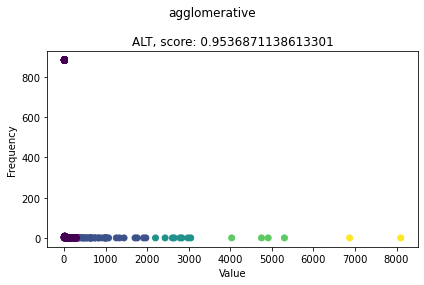

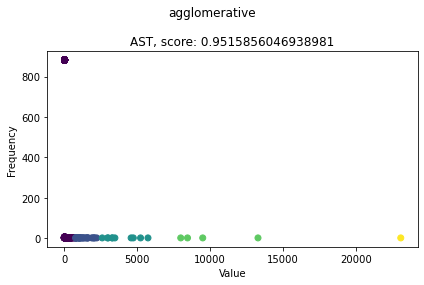

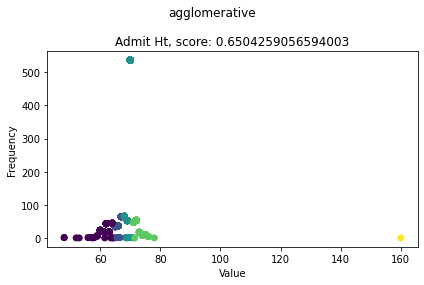

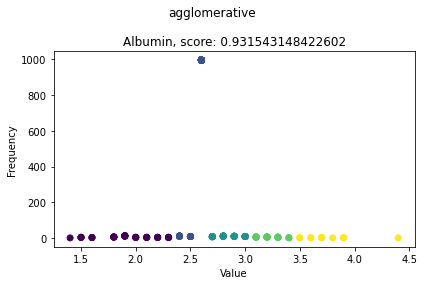

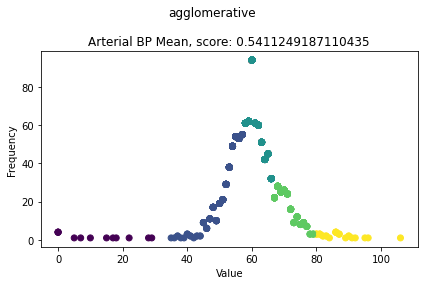

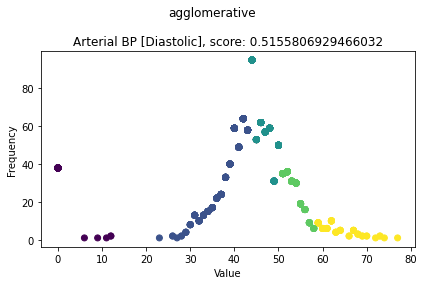

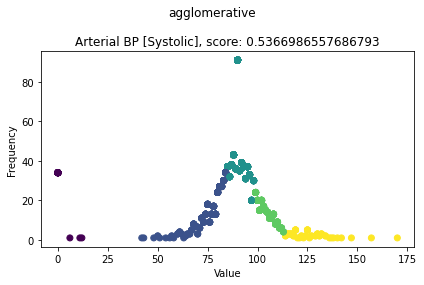

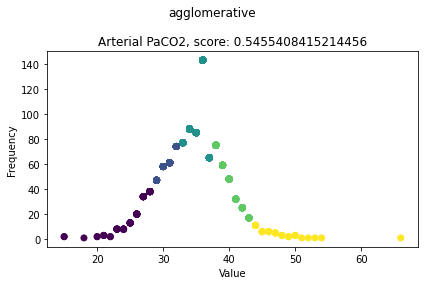

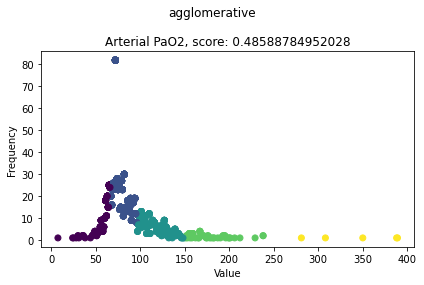

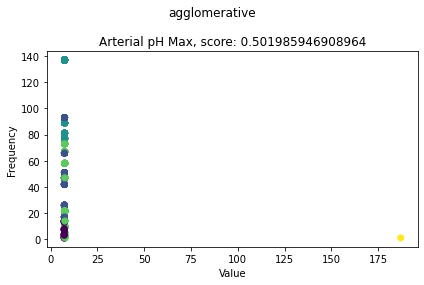

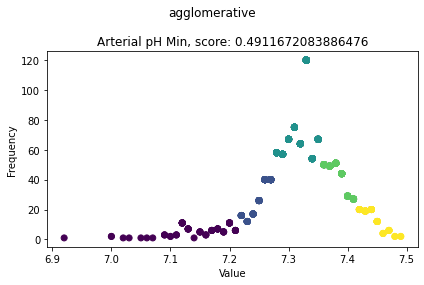

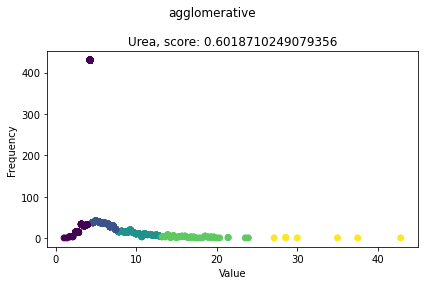

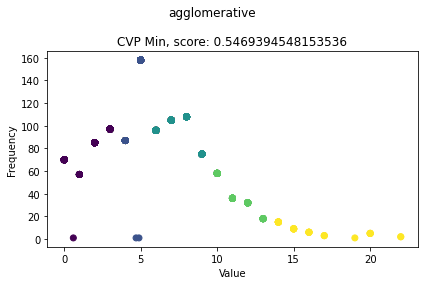

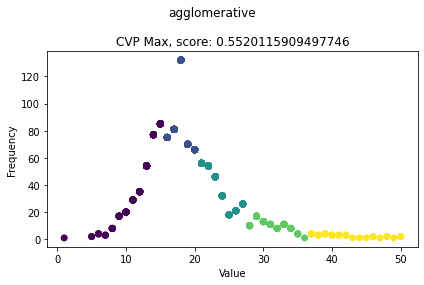

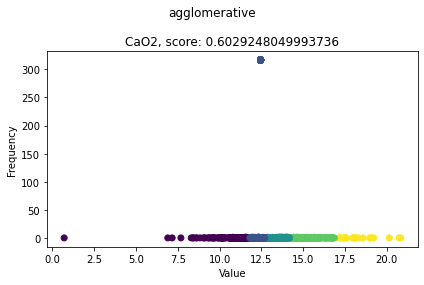

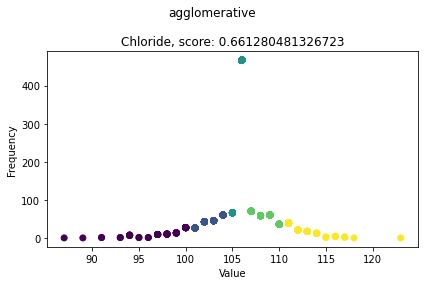

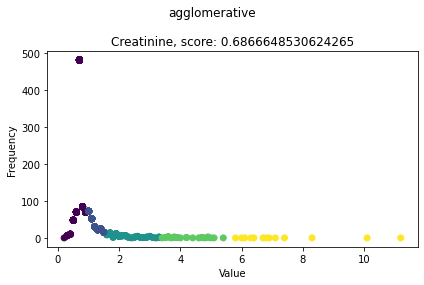

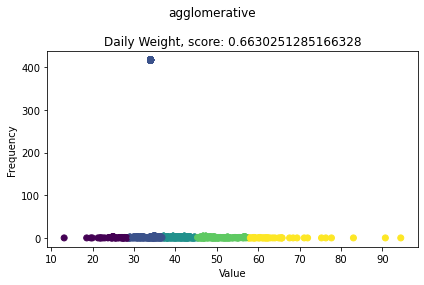

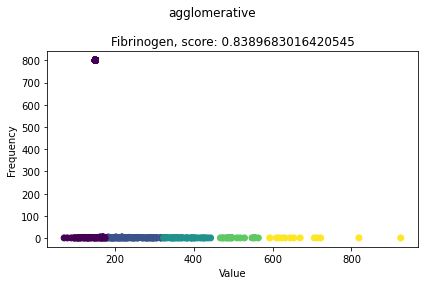

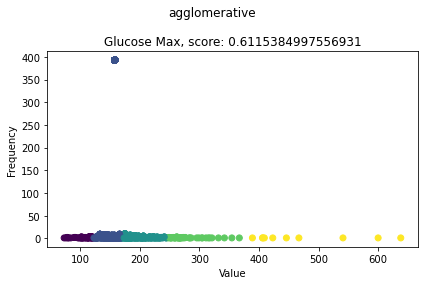

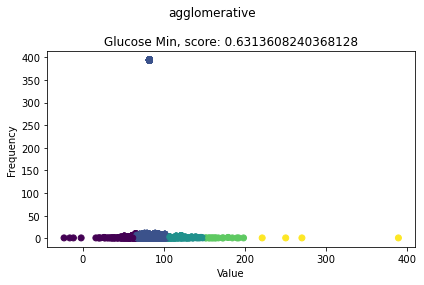

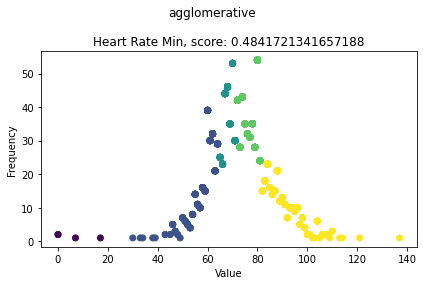

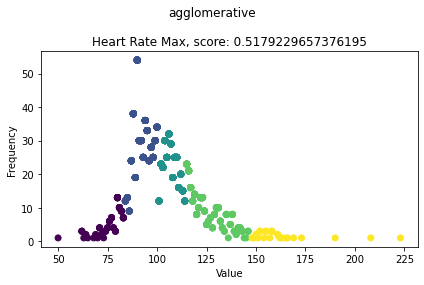

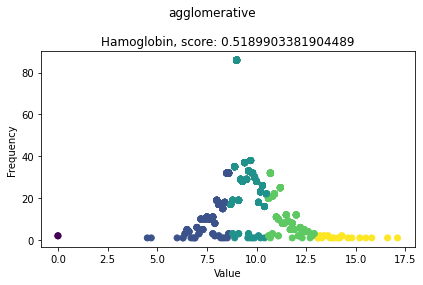

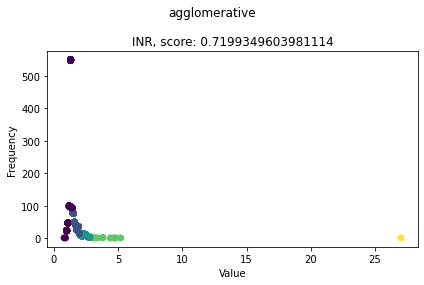

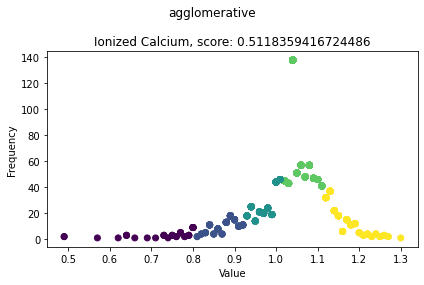

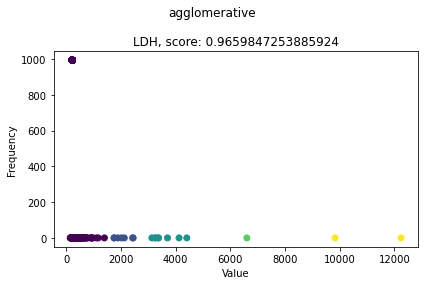

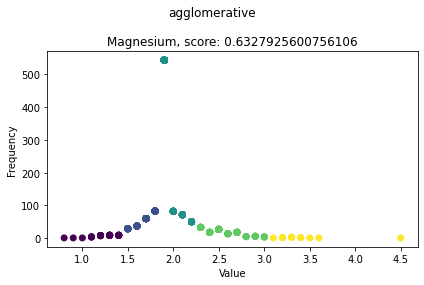

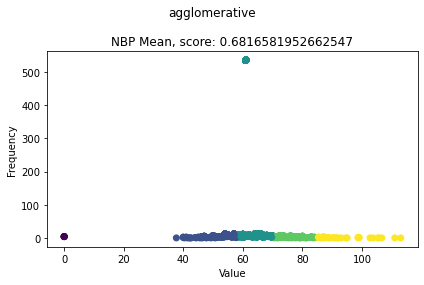

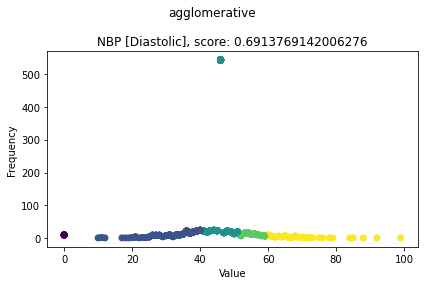

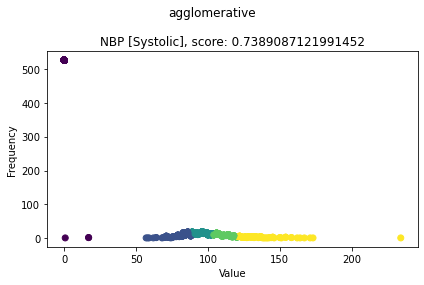

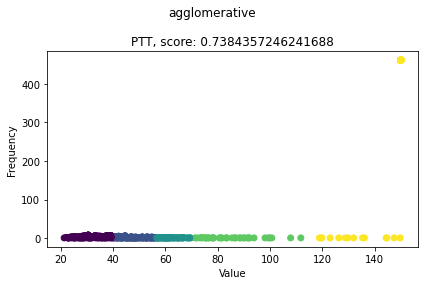

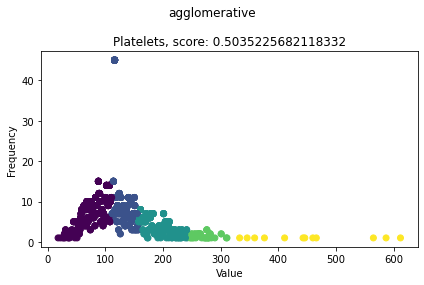

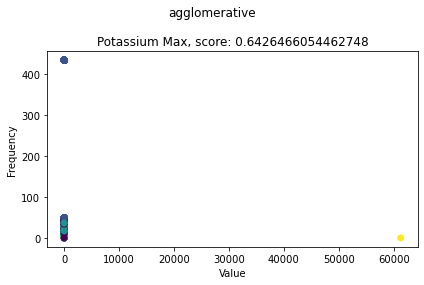

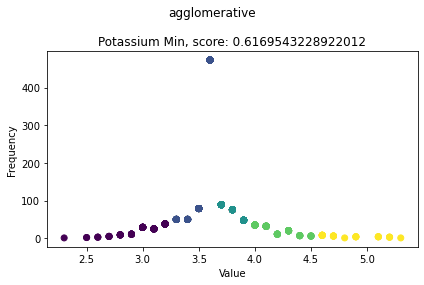

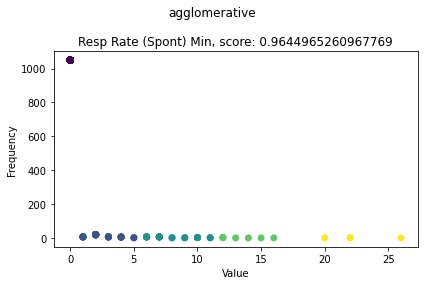

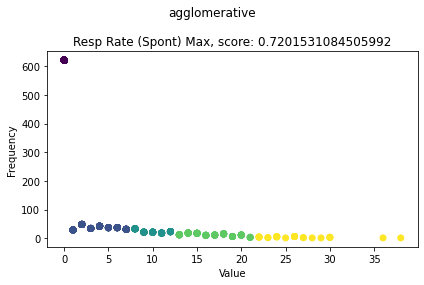

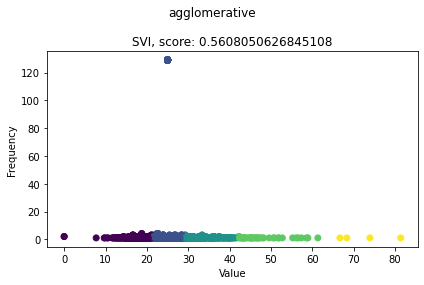

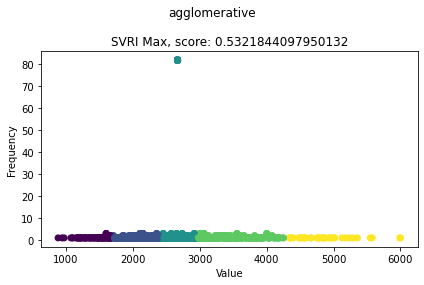

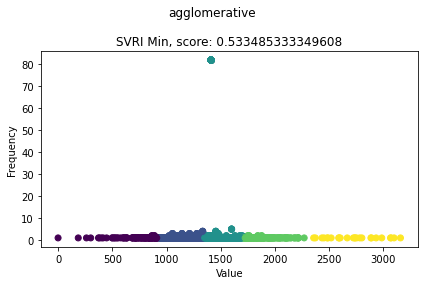

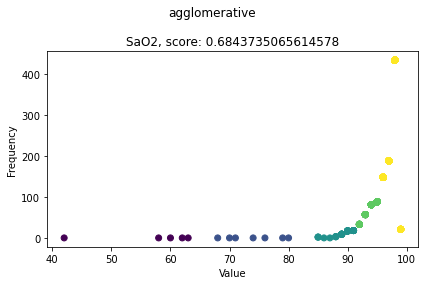

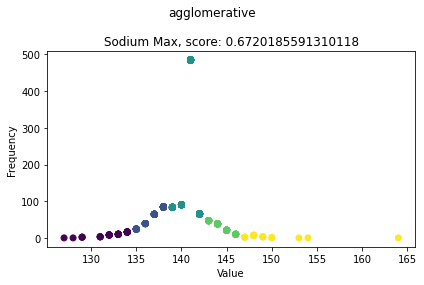

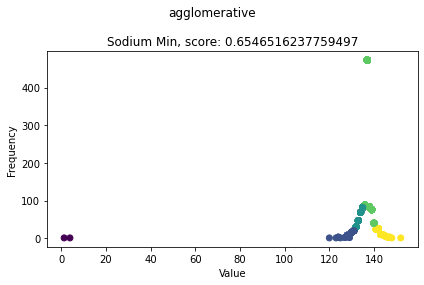

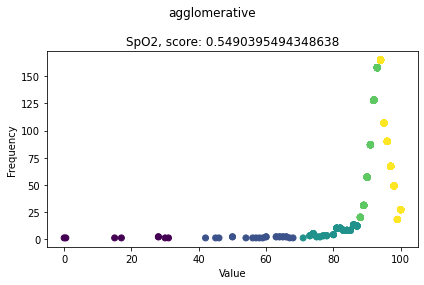

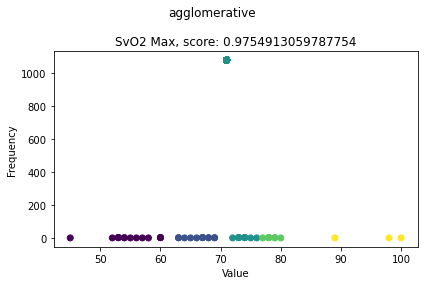

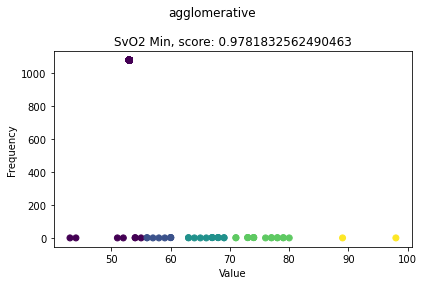

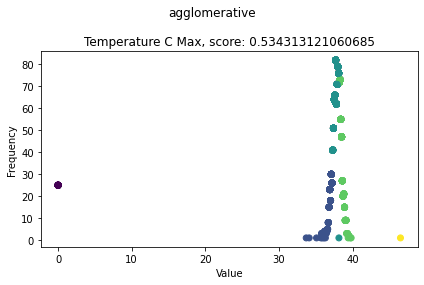

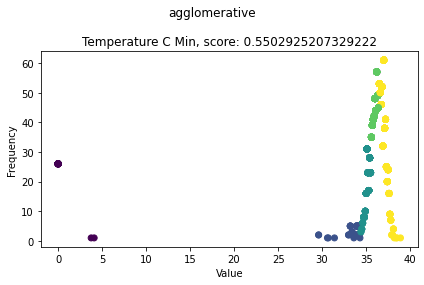

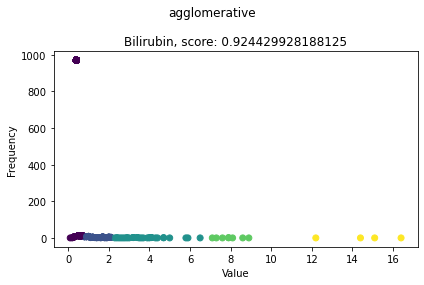

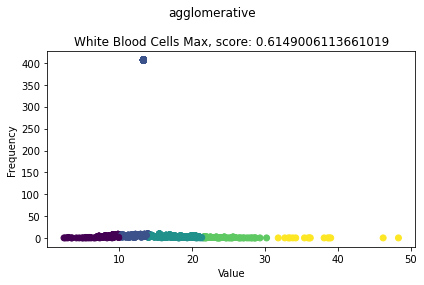

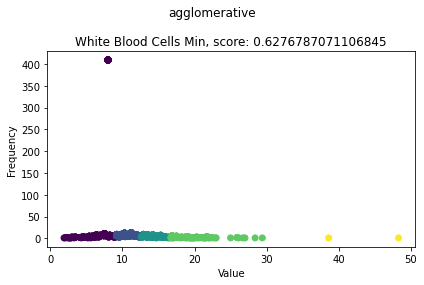

In [21]:
cat = Categorizer(fillNaModeDF)

# cat.kBins(bins = 5)
cat.agglomerative(n_clusters = 5)
# cat.kMeans(n_clusters = 5)

cat.display()